In [ ]:
from jupyterthemes import jtplot
jtplot.style(figsize = (15, 10), grid = False, ticks = True)

In [ ]:
import numpy as np
import pandas as pd
# ML
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

import cv2
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torchvision

# Plots
import matplotlib.pyplot as plt

# Utils
from tqdm import tqdm, trange
import os

## Utils

# Pytorch API

Package| 	Description|
-|-|
`torch`| 	The top-level PyTorch package and tensor library.
`torch.nn`| 	A subpackage that contains modules and extensible classes for building neural networks.
`torch.autograd`| 	A subpackage that supports all the differentiable Tensor operations in PyTorch.
`torch.nn.functional`| 	A functional interface that contains typical operations used for building neural networks like loss functions, activation functions, and convolution operations.
`torch.optim`| 	A subpackage that contains standard optimization operations like SGD and Adam.
`torch.utils`| 	A subpackage that contains utility classes like data sets and data loaders that make data preprocessing easier.
`torchvision`| 	A package that provides access to popular datasets, model architectures, and image transformations for computer vision. 

# Tensors

## Tensor introduction

 Each of these examples are specific instances of the more general concept of a tensor:
- number / scalar
- array / vector
- 2d-array / matrix

Tensors are generalizations: $n$d-arrays

In [ ]:
x = torch.tensor([1, 2, 3])
x

In [ ]:
# Dtypes
x = torch.tensor([1, 2, 3], dtype = torch.float32)
x

In [ ]:
x = torch.tensor(2)
x

In [ ]:
x.item(), type(x.item())

### Get information about a tensor

In [ ]:
print(f"Shape of tensor: {x.shape}")
print(f"Datatype of tensor: {x.dtype}")
print(f"Device tensor is stored on: {x.device}")

### Tensor operations

#### Matrix Operations

In [ ]:
x = torch.tensor([[1, 2, 3],
                 [4, 5, 6]], dtype = torch.float32)

In [ ]:
print(x.sum())
print(x.sum(axis = 0))
print(x.sum(axis = 1))

In [ ]:
y = 2 * torch.ones((3, 2))
y

- Matrix multiplication
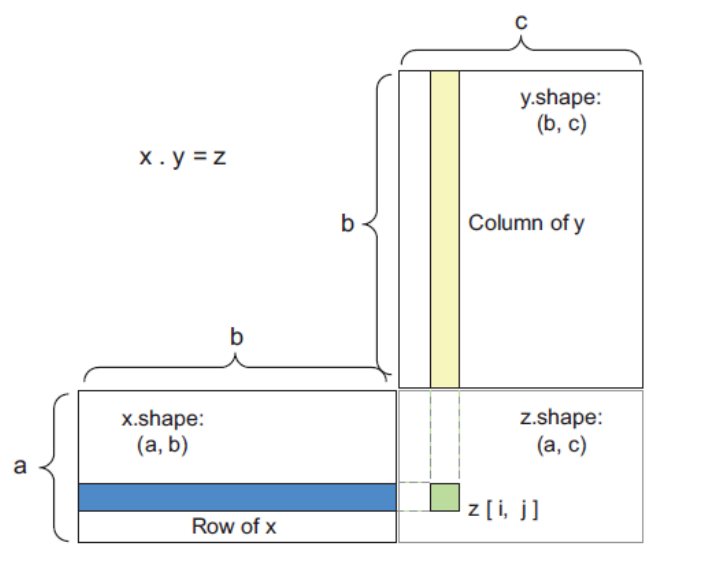

In [ ]:

print(x.matmul(y))
print(x @ y)

In [ ]:
x + 1

In [ ]:
x * y.T

#### Reshape, squeeze, flatten

In [ ]:
print(x)
print(x.reshape(3, 2))
print(x.flatten())

In [ ]:
print(x, x.shape)
print()
print(x.unsqueeze(0), x.unsqueeze(0).shape)

print(x.unsqueeze(-1), x.unsqueeze(-1).shape)

print(x.unsqueeze(1), x.unsqueeze(1).shape)


### Concatenation

In [ ]:
x = torch.tensor([[1, 2, 3],
                 [4, 5, 6]])
y = torch.tensor([[10, 20, 30],
                 [40, 50, 60]])

torch.cat([x, y], dim = 0)

In [ ]:
torch.cat([x, y], dim = 1)

## Usual tensor dimensions used in practice

1. 2D - Numerical data (Vector data):
- `(num_samples, num_features)`
2. 3D - Time series: 
- `(num_samples, num_timesteps, num_features)`
3. 4D - Image data: 
- `(num_samples, height, width, channels)` or `(channels, num_samples, height, width)`
4. 5D - Video:
- `(num_samples, frames, height, width, channels)`



# Cuda

## Device 

In [ ]:
torch.cuda.is_available()

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

In [ ]:
torch.cuda.get_device_properties(0)

In [ ]:
torch.cuda.device_count()

## Memory

In [ ]:
print(torch.cuda.memory_summary(abbreviated=True))

In [ ]:
def print_memory_stats(mb = True):
    d = 1
    if mb == True: 
        d = 1024 * 1024
        
    t = torch.cuda.get_device_properties(0).total_memory / d
    r = torch.cuda.memory_reserved(0) / d
    a = torch.cuda.memory_allocated(0)  / d
    f = r-a  # free inside reserved
    print(f"total memory: {t} MB")
    print(f"reserved memory: {r} MB")
    print(f"allocated memory: {a} MB")
    print(f"free memory inside reserved : {f} MB")
    #return t, r, a, f

In [ ]:
# Look at memory
print_memory_stats()

In [ ]:
x = torch.rand(1000000)
x, x.device

In [ ]:
# Put a tensor into gpu memory
x = x.cuda()
print(x.device)
print_memory_stats()

In [ ]:
# Try to empty cache. It's the same since we have a reference to `x`
torch.cuda.empty_cache()
print_memory_stats()

In [ ]:
# Delete x and look at memory. 
del x
print_memory_stats()

In [ ]:
#Indeed, we can't acces `x` anymore
x

In [ ]:
# Try to empty cache. 
torch.cuda.empty_cache()
print_memory_stats()

In [ ]:
torch.tensor([1, 2, 3]).cuda()
print_memory_stats()

In [ ]:
def pretty_size(size):
    """Pretty prints a torch.Size object"""
    assert(isinstance(size, torch.Size))
    return " × ".join(map(str, size))

def dump_tensors(gpu_only=True):
    """Prints a list of the Tensors being tracked by the garbage collector."""
    import gc
    total_size = 0
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj):
                if not gpu_only or obj.is_cuda:
                    print(f'{type(obj).__name__}: {" GPU" if obj.is_cuda else ""}{" pinned" if obj.is_pinned else ""} {pretty_size(obj.size())}')
                    total_size += obj.numel()
            elif hasattr(obj, "data") and torch.is_tensor(obj.data):
                if not gpu_only or obj.is_cuda:
                    print("%s → %s:%s%s%s%s %s" % (type(obj).__name__, 
                                                   type(obj.data).__name__, 
                                                   " GPU" if obj.is_cuda else "",
                                                   " pinned" if obj.data.is_pinned else "",
                                                   " grad" if obj.requires_grad else "", 
                                                   " volatile" if obj.volatile else "",
                                                   pretty_size(obj.data.size())))
                    total_size += obj.data.numel()
        except Exception as e:
            pass        
    print("Total size:", total_size)

In [ ]:
x = torch.rand((100, 100, 100)).cuda()
y = torch.rand((2134, 4444)).cuda()
dump_tensors()

In [ ]:
del x, y

In [ ]:
dump_tensors()

## GPU to CPU

In [ ]:
x = torch.rand((100, 100, 100)).cuda()
dump_tensors()

In [ ]:
x = x.cpu()

In [ ]:
dump_tensors()

In [ ]:
del x

In [ ]:
dump_tensors()

In [ ]:
print_memory_stats()

In [ ]:
torch.cuda.empty_cache()
print_memory_stats()

# Data

## Dataset, DataLoader

- https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
class MyDataset(Dataset):
    def __init__(self):
        numbers = np.arange(100)
        self.data = numbers
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index]

In [ ]:
dataset = MyDataset()
print(len(dataset))
print(dataset.data)

In [ ]:
dataloader = DataLoader(dataset, batch_size = 10, shuffle = True)
for i, batch in enumerate(dataloader):
    print(i, batch)

# Training

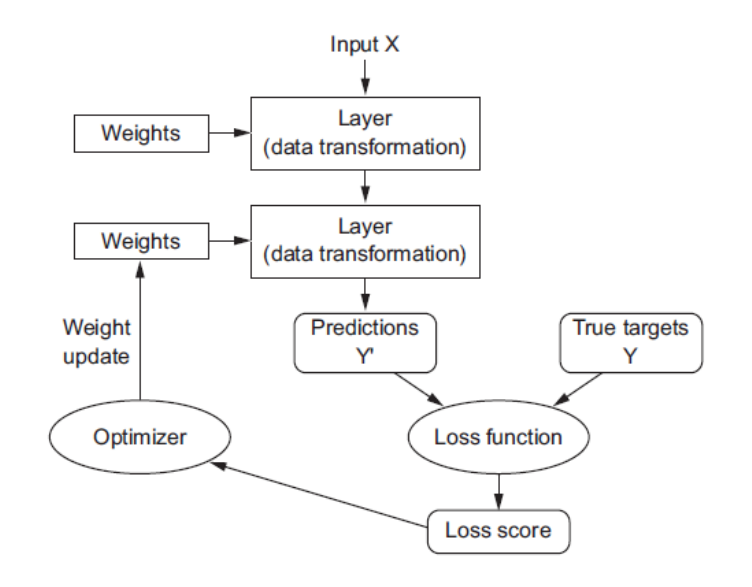

## Data

In [ ]:
import pandas as pd

df_train =  pd.read_csv('../lab5/mnist/mnist_train.csv')
df_test =  pd.read_csv('../lab5/mnist/mnist_test.csv')

X_train, y_train = df_train.drop('label', axis = 1).to_numpy(), df_train['label'].to_numpy()
X_test, y_test = df_test.drop('label', axis = 1).to_numpy(), df_test['label'].to_numpy()
X_train = X_train / 255
X_test = X_test / 255

In [ ]:
X = np.concatenate([X_train, X_test])
y = np.concatenate([y_train, y_test])
X.shape, y.shape

In [ ]:
G = 16
X_sel = X[:G * G]
plt.figure(figsize = (10, 10))
plt.imshow(np.concatenate(X_sel.reshape(G, 28 * G, 28), axis = 1))

In [ ]:
class DigitsDataset(Dataset):
    def __init__(self, X, y):
        # Make your own dataset. Include self.num_features, self.num_classes for ease of use
        # Code here
        

In [ ]:
dataset = DigitsDataset(X, y)
#dataloader = DataLoader(dataset, batch_size = 64, shuffle = True)

In [ ]:
from torch.utils.data import random_split

train_len = int(.8 * len(dataset))
test_len = len(dataset) - train_len

train_dataset, test_dataset = random_split(dataset, [train_len, test_len])

## Models

In [ ]:
class Model(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Model, self).__init__()
        # Hidden layers
        self.fc = nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        x = self.fc(x)
        return F.softmax(x, dim = 1)
    
# Make and use a stronger model


In [ ]:
input_shape = dataset.num_features
output_shape = dataset.num_classes
model = Model(input_shape, output_shape)
#model.cuda()

In [ ]:
model

In [ ]:
for p in model.parameters():
    print(p.shape)
    #print(p)

## Optimizers, loss

In [ ]:
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

loss_function = nn.CrossEntropyLoss()

## Training

In [ ]:
torch.argmax(model(X_batch), axis = 1)

In [ ]:
X_batch.shape

In [ ]:
batch_size = 64
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(train_dataset, batch_size=len(test_dataset))

In [ ]:
epochs = 5
accs = []
losses = []
model.train() # Set the model to training mode
for epoch in (t:= trange(epochs)):
    
    loss_epoch = 0.
    acc = 0.
    num_batches = 0
    for X_batch, y_batch in trainloader:
        num_batches +=1
        y_pred = model(X_batch)
        
        loss = loss_function(y_pred, y_batch)    
        loss_epoch += loss.item()
        
        acc += accuracy_score(torch.argmax(y_pred, axis = 1), y_batch)
        
        optimizer.zero_grad() # don't forget this
        loss.backward()
        optimizer.step()
    
    acc /= num_batches
    loss_epoch /= num_batches
    losses.append(loss_epoch)
    accs.append(acc)
    t.set_description(f"Loss: {round(loss_epoch, 2), round(acc, 2)}")

## Evaluate

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (20, 5))

axs[0].plot(losses)
axs[1].plot(accs)

In [ ]:
model.eval()
X_test, y_test = test_dataset.dataset.X, test_dataset.dataset.y
y_pred= model(X_test)

print(accuracy_score(torch.argmax(y_pred, axis = 1), y_test))